<a href="https://www.kaggle.com/code/lukalafaye/mnist-classification?scriptVersionId=201553364" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classifying digits using a fully connected neural network

In this practical exercice a fully connected neural network (also called multi-layer perceptron) is built using keras. It is then trained to classify image digits from the MNIST database. The MNIST database is a set of 28x28 grey-level, centered images of digits.

Some baseline results:

| Method                                                                      | Test error (%) |
|-----------------------------------------------------------------------------|---------------:|
| Linear classifier (LeCun et al. 1998)                                       |           12.0 |
| K-nearest-neighbors, Euclidean (L2) (LeCun et al. 1998)                     |            5.0 |
| 3-layer NN, 500-300, softmax, cross entropy, weight decay (Hinton, 2005)    |            1.5 |
| Convolutional net LeNet-4 (LeCun et al. 1998)                               |            1.1 |
| Virtual SVM deg-9 poly [data augmentation] (LeCun et al. 1998)              |            0.8 |
| 6-layer NN with [data augmentation] (Ciresan et al. 2010)                   |           0.35 |
| Deep conv. net, 7 layers [data augmentation] (Ciresan et al. IJCAI 2011)    |           0.35 |

More results are available from: http://yann.lecun.com/exdb/mnist/

Try to improve on some of these results, at least on those that do not use data augmentation or convolutional neural networks.

Teaching assistant: romain.vo@mines-paristech.fr

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.keras import backend as K
from tensorflow.keras.datasets import mnist as db
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2


## Data

The MNIST dataset is a widely used baseline for classifcation, and deep learning methods specifically, and as such is directly available through the keras API. The data is split in training and test set.

In [2]:
# Load the data
(x, y), (x_test_ori, y_test_ori) = db.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## First look

Have a look at the data. You can run the next cell several times to have a look at different instances of the same class.

**#i** here denotes the number of samples which belongs to the class **i**.

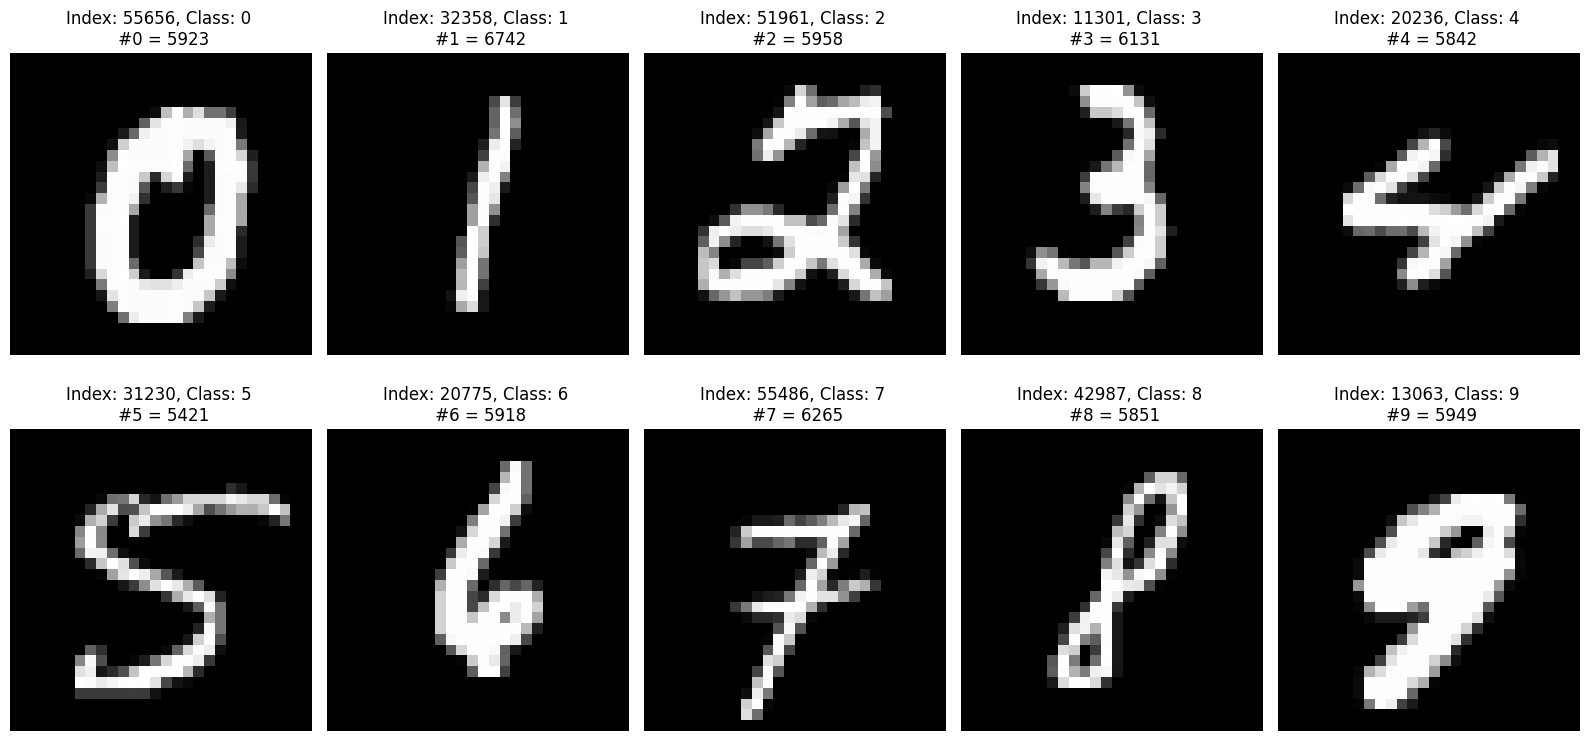

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
ax = ax.reshape(-1)

for i in range(10):
    class_mask = np.nonzero(y == i)[0]
    index = np.random.choice(class_mask)
    ax[i].imshow(x[index])
    ax[i].axis('off')
    ax[i].set_title(f"Index: {index}, Class: {y[index]} \n #{y[index]} = {class_mask.shape[0]}")

fig.tight_layout()

### Data preparation

<u>Splitting :</u> The training subset of the MNIST database contains 60000 images. We will split this set into an effective training set (90%) and a validation set (10%). This will allow us to improve our model without looking at the test set. As a rule of thumb the test should be evaluated very very few times, only when you think you have reach the end of your improvement procedure.

<u>Normalization :</u> We need to normalize the data before feeding it to the neural network, this is done simply by dividing the pixel values by 255.

<u>Formatting the input:</u> For the moment, the training data (the images) are stored in 2D arrays. Because we are using *Fully connected layers* (**FCL**), also called *Multi-Layer Perceptron* (**MLP**), we only need 1D vector as input. Thus we flatten the 2D arrays beforehand.
- `x[idx].shape = (28,28)`  $\rightarrow$  `x[idx].shape = (784)`

<u>Formatting the output:</u> For the moment, the target is simply stored by assigning to each index of the `y` array, the corresponding digit value. Here our future **MLP** will compute an `output` tensor of 10 "probabilities" (between 0 and 1) for each image. Thus for an image of the digit `8` we would like `output[7]` to be equal to 1. To learn such a network we also need to format the `y` array into a relevant encoding. So we apply a *one-hot encoding* to each value stored in `y` :
- `y[idx] = 8`  $\rightarrow$  `y[idx] = [0, 0, 0, 0, 0, 0, 0, 1, 0]`

In [4]:
# Data management
val_nb = 6000  # number of validation samples
nb_samples = x.shape[0]

if val_nb > nb_samples:
    raise ValueError("You need some samples to train your network!")

img_width, img_height = x.shape[1], x.shape[2]

num_of_pixels = img_width * img_height

# As we are using only fully connected layers, we need a vector as input
x = x.reshape(nb_samples, num_of_pixels)
x_test = x_test_ori.reshape(x_test_ori.shape[0], num_of_pixels)

# Normalization
x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

x_val = x[:val_nb, ]
x_train = x[val_nb:, ]
y_val = y[:val_nb]
y_train = y[val_nb:]

# one-hot encoding of classes
num_classes = max(y) + 1
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test_ori, num_classes)


print(x_train.shape, 'x train samples')
print(x_val.shape, 'x val samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_val.shape, 'y val samples')
print(y_test_ori.shape, 'y test samples')

(54000, 784) x train samples
(6000, 784) x val samples
(10000, 784) x test samples
(54000, 10) y train samples
(6000, 10) y val samples
(10000,) y test samples


## First model

We will begin with a network containing a single layer. We use a `softmax` activation for our last and single layer in order to normalize the `output` tensor.


In [5]:
# let define a first simple model without any hidden layers
model = Sequential()
model.add(Input(x_train.shape[1:]))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

### Training

The following section takes care of training.

Firstly, the model has to be 'compiled'. This operations lets the user to choose the loss, the optimizer and the metrics, then configures the model for training.

<u>Loss :</u> To train our model we choose a *categorical cross-entropy*, with $N$ the number of samples and $C$ the number of classes:
- $L(y, \hat{y}) = \frac{1}{N} \sum_{i=0}^N \left( - \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c}) \right)$  

Implement a categorical cross-entropy using only `K.log`, `K.sum` , `K.mean`

To check that your implement of `categorical_crossentropy` is correct, you should approximately have the same results when setting `loss='categorical_crossentropy'`, which uses the built-in implementation of keras.

<u>Optimization :</u> Secondly, the 'fit' method runs the optimization. Training and validation data are specified here, as well as batch size and the number of epochs.


In [6]:
import tensorflow as tf

In [7]:
learning_rate = 0.01

def categorical_crossentropy(target, prediction):
    """
    target : array of shape [batch_size, num_classes]
    prediction : array of shape [batch_size, num_classes]
    """
    small_value = 1e-10
    log_preds = K.log(prediction + small_value)
    loss = -K.sum(log_preds * target, axis=-1)
    return K.mean(loss)

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(learning_rate=learning_rate),
#               metrics=['accuracy'])

Note that you can run the cell below several times. Training will restart from the point it stopped in the previous run. However variable *output* will only contain the history of the last run.

In [8]:
batch_size = 128
epochs = 10
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val))

Epoch 1/10


I0000 00:00:1728910901.745239     100 service.cc:145] XLA service 0x7fafc000f230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728910901.745281     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728910901.745284     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


110/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3115 - loss: 2.0450

I0000 00:00:1728910902.658425     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5383 - loss: 1.6547 - val_accuracy: 0.8263 - val_loss: 0.8488
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8303 - loss: 0.7979 - val_accuracy: 0.8568 - val_loss: 0.6346
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8529 - loss: 0.6324 - val_accuracy: 0.8688 - val_loss: 0.5472
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8621 - loss: 0.5597 - val_accuracy: 0.8747 - val_loss: 0.4980
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8709 - loss: 0.5141 - val_accuracy: 0.8810 - val_loss: 0.4657
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8786 - loss: 0.4785 - val_accuracy: 0.8860 - val_loss: 0.4426
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8790 - loss: 0.4625 - val_accuracy: 0.8898 - val_loss: 0.4252
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8832 - loss: 0.4423 - val_accuracy: 0.8915 - val_

### Is training satisfactory?

Looking at the evolution of training and validation accuracies, one can evaluate the quality of training.

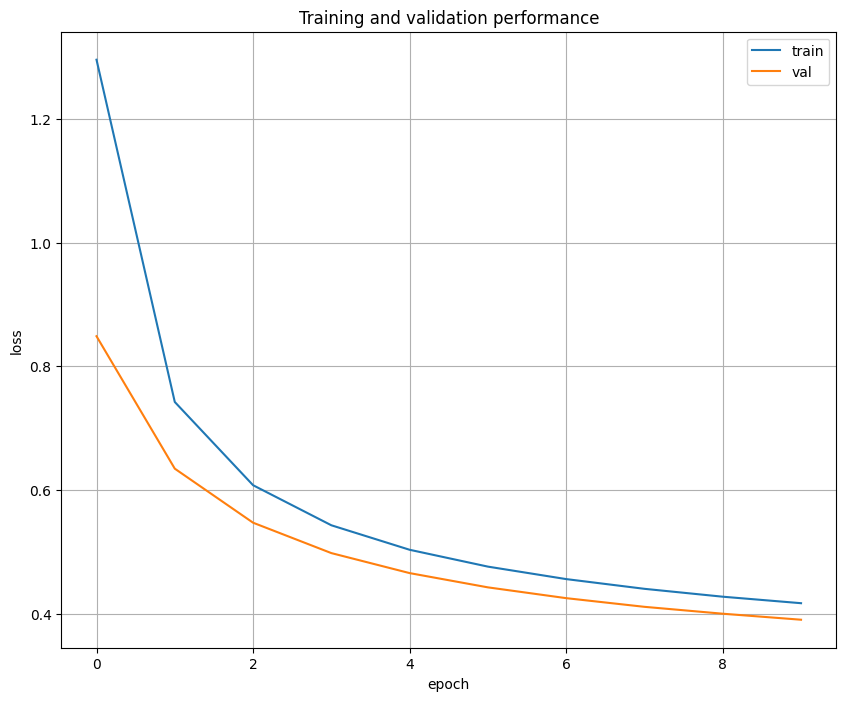

In [9]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()
plt.show()

### Questions



*   Do you think learning could be improved? Why?

**Answer**: ...
More epochs would seem to improve validation performance...


*   Is there overfitting? Why?

**Answer**: ...
Not yet



In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.388
Test accuracy: 0.898


### Analysis of the weights

With this simple model it is possible to have an intuition of what the neural network has learned looking at
the matrix of the weights $W$.
In fact $W\in\mathbb{R}^{784\times 10}$, so for each class $i$ we can plot the weights corresponding to this class.

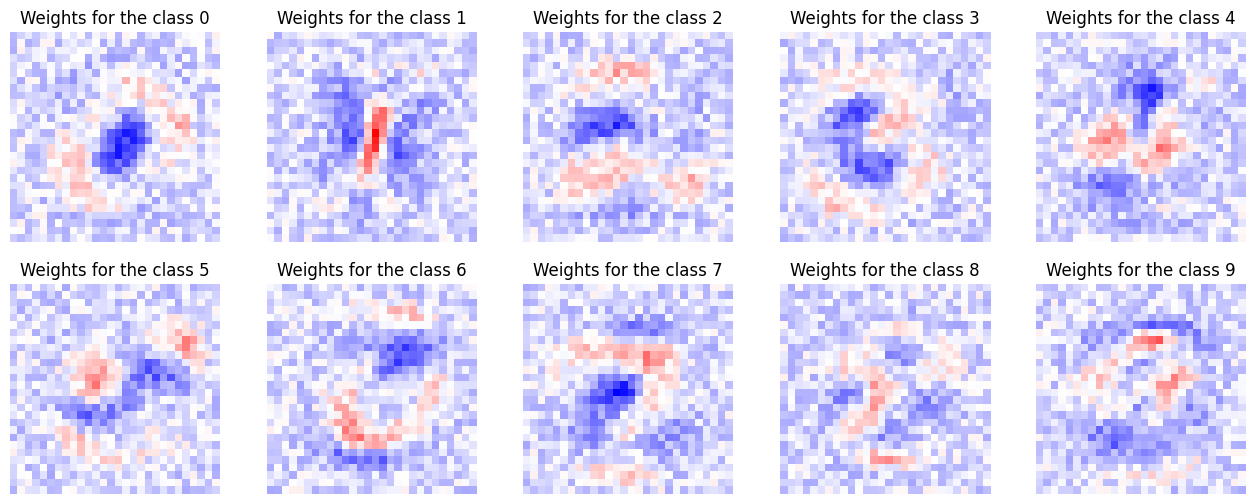

In [11]:
# plotting the weights
W, b = model.layers[0].get_weights()
vmin = W.min()
vmax = W.max()
f, ax = plt.subplots(2, 5, figsize=(16,6))
for plt_row in range(2):
    for plt_col in range(5):
        ax[plt_row][plt_col].imshow(W[:,plt_row*5 + plt_col].reshape(img_width,img_height), vmin=vmin, vmax=vmax, cmap=plt.cm.bwr)
        ax[plt_row][plt_col].axis('off')
        ax[plt_row][plt_col].set_title("Weights for the class {}".format(plt_row*5 + plt_col))
plt.show()

## Improving performance by adding extra layers

In order to improve the performances of our prediction it is possible to add hidden layers between the input layer and the output layer.

Note that here we are restricted to dense layers. Do not use (yet) other types of layers.

In [12]:
model = Sequential()
model.add(Input(x_train.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax', name="last"))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [14]:
batch_size = 64
epochs = 40
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6032 - loss: 1.4756 - val_accuracy: 0.8870 - val_loss: 0.4270
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8856 - loss: 0.4127 - val_accuracy: 0.9112 - val_loss: 0.3219
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9045 - loss: 0.3331 - val_accuracy: 0.9223 - val_loss: 0.2837
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9165 - loss: 0.2883 - val_accuracy: 0.9268 - val_loss: 0.2611
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9255 - loss: 0.2620 - val_accuracy: 0.9323 - val_loss: 0.2383
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9290 - loss: 0.2480 - val_accuracy: 0.9362 - val_loss: 0.2229
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9342 - loss: 0.2319 - val_accuracy: 0.9400 - val_loss: 0.2088
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9400 - loss: 0.2126 - val_accuracy: 0.

### Analysis of the results




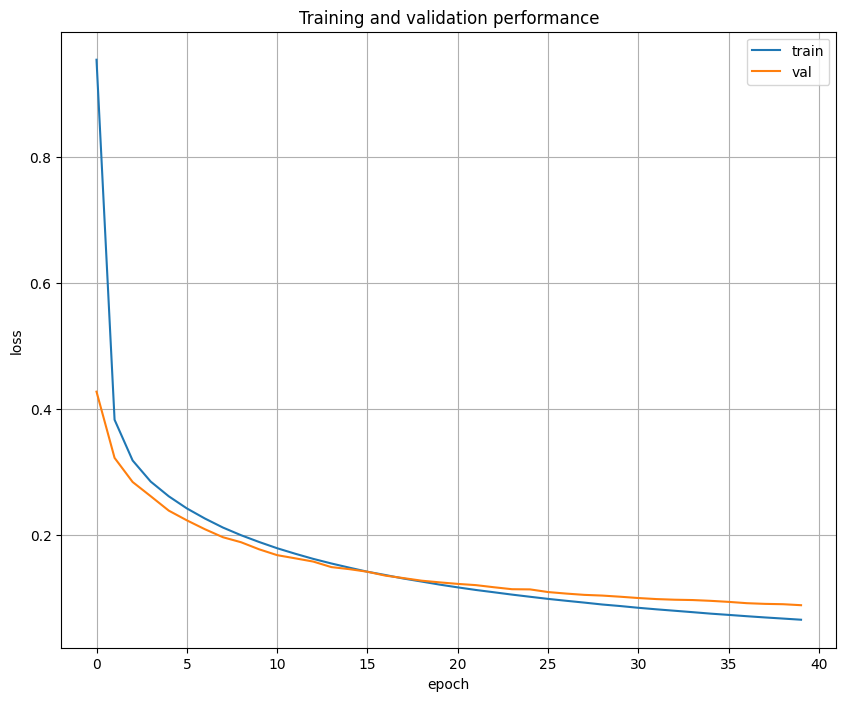

In [15]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()
# plt.ylim(0.2, 0.8)

Is there overfitting? How can it be reduced?

**Answer**: There is a little overfitting, the val accuracy is not getting much better while the training loss keeps decreasing. It can be reduced using regularization methods, adding more data,...

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.094
Test accuracy: 0.970


### Qualitative error analysis

Let us have a look at some images that have been incorrectly classified.

<u>Inference </u>: We call the `predict` method on our model and feed the `x_test` array to obtain the probabilities for each test sample. The `y_predict_proba` is a *one-hot encoded* array so we compute the index of the maximum predicted probability to extract the label of the predicted digit

In [17]:
y_predict_proba = model.predict(x_test)
y_predict = np.argmax(y_predict_proba, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


You can run the following cell several times to inspect different errors, or manually change the `index` variable

Correct label is: 9
Predicted label is: 3 with a "probability" of 36.53%
Label 9 was predicted with a "probability" of 27.41%

Probabilities: [9.29820091e-02 2.78198398e-09 1.23383954e-01 3.65330100e-01
 1.09139255e-05 3.61630763e-03 6.90743661e-07 6.52360322e-05
 1.40518606e-01 2.74092197e-01]


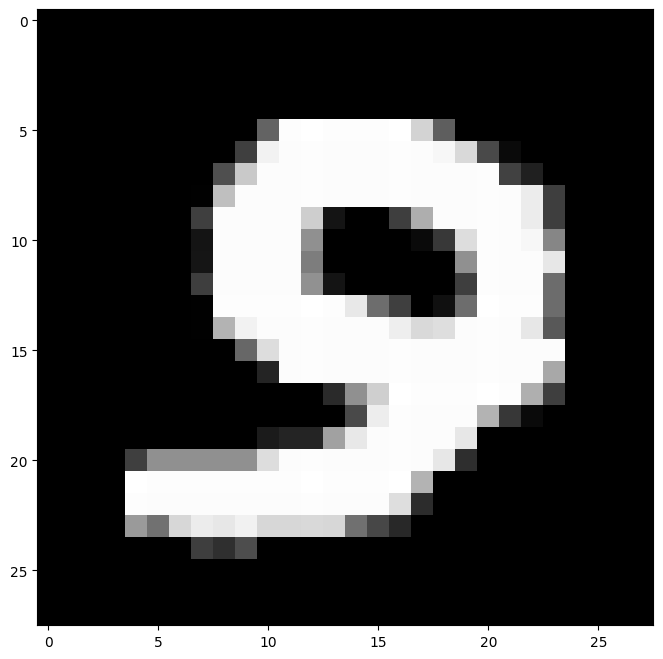

In [18]:
rng = np.random.default_rng(10)

err_mask = y_test_ori != y_predict
ok_mask = y_test_ori == y_predict

x_test_errors = x_test_ori[err_mask]
y_test_errors = y_test_ori[err_mask]
y_predict_errors = y_predict[err_mask]
y_predict_proba_errors = y_predict_proba[err_mask]
y_predict_proba_ok = y_predict_proba[ok_mask]

index = rng.choice(range(y_test_errors.shape[0]))
print(f"Correct label is: { y_test_errors[index]}")
print(f"Predicted label is: {y_predict_errors[index]} with a \"probability\" of {y_predict_proba_errors[index, y_predict_errors[index]]:.2%}")
print(f"Label {y_test_errors[index]} was predicted with a \"probability\" of {y_predict_proba_errors[index, y_test_errors[index]]:.2%}", end='\n\n')
print(f"Probabilities: {y_predict_proba_errors[index]}")
plt.imshow(x_test_errors[index], cmap="gray")
plt.show()

We can plot the histogram of the probabilities of the predicted classes, given that the predictions are correct or incorrect. This should give us some intuitions on how the network "behaves" during inference

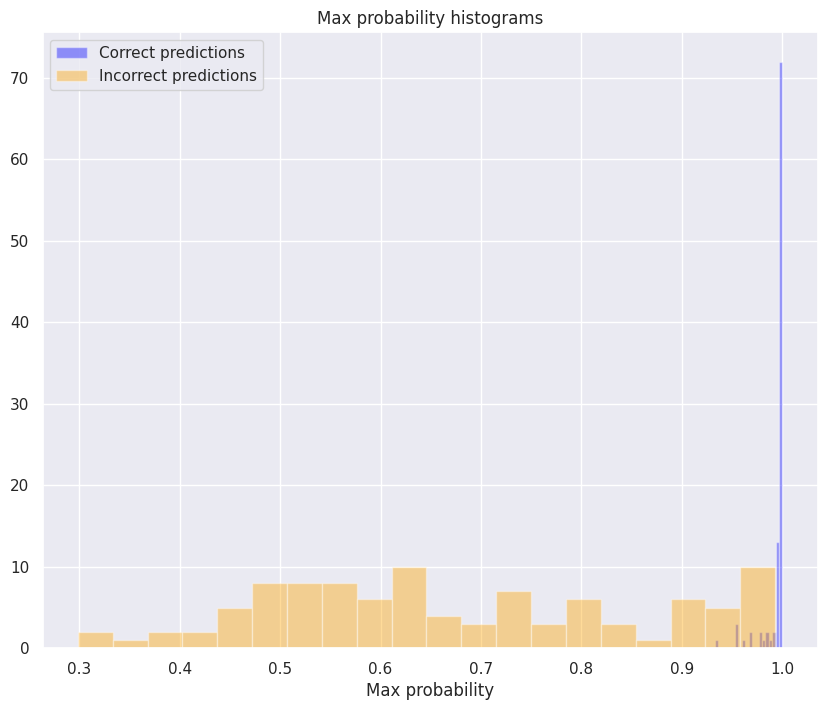

In [19]:
%matplotlib inline

# p.max() keeps the highest probability among the 10 outputs.

max_predictions_correct = np.max(y_predict_proba[ok_mask], 1)
max_predictions_incorrect = np.max(y_predict_proba[err_mask], 1)

# np.random.shuffle shuffles the values of the array
np.random.shuffle(max_predictions_correct)
np.random.shuffle(max_predictions_incorrect)

y_predict_proba_errors.shape

histo_bins = 20
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()

ax.hist(max_predictions_correct[0:100], density=False,
         bins=histo_bins,
         color="blue",
         alpha=0.4,
         label='Correct predictions')
ax.hist(max_predictions_incorrect[0:100],density=False,
         bins=histo_bins,
         color="orange",
         alpha=0.4,
         label='Incorrect predictions')

ax.set_title('Max probability histograms')
ax.set_xlabel("Max probability")
ax.legend()

sns.reset_defaults()


Is the network 'confident' when making errors?

**Answer**: It can be (looking at the right of the graph), out of 100 incorrect samples more than 25 have a probability >0.8 of being chosen.

What do you think about these errors?

**Answer**: I think they can be fixed by over sampling methods for the classes where predictions are incorrect as well as using a threshold for the classification.

### Quantitative error analysis

We can measure the uncertainty of our model by measuring the entropy of its predictions. In [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory)) the entropy of a random variable is given by $H(X) = - \sum_{x \in \mathcal{X}} p(x) \log\left(p(x)\right)$. In our case we can compute the entropy of a prediction using:
- $H(\hat{y}) = - \sum_{c=1}^C \hat{y}_{c} \log(\hat{y}_{c})$

In [20]:
def entropy(predictions):
    return - np.sum(predictions * np.log(predictions), axis=1)

We will plot the smoothed histogram (Kernel Density Estimation) of our predictions' entropy, given that the predictions are correct or incorrect.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


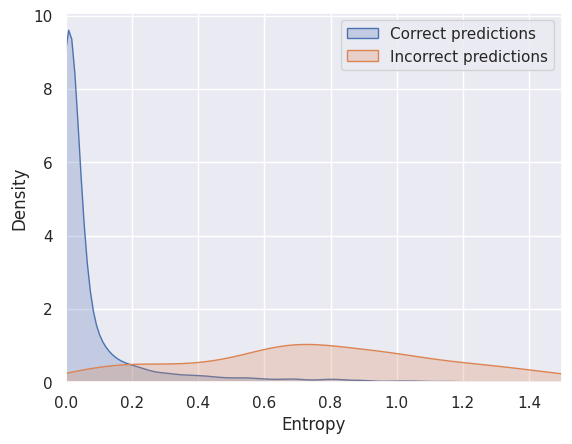

In [21]:
%matplotlib inline
sns.set_theme()

entropies = entropy(y_predict_proba)

fig, ax = plt.subplots()
sns.kdeplot(entropies[ok_mask], label='Correct predictions', ax=ax, fill=True)
sns.kdeplot(entropies[err_mask], label='Incorrect predictions',ax=ax, fill=True)
ax.set_xlim(0, 1.5)
ax.set_xlabel('Entropy')

ax.legend()

sns.reset_defaults()

From this plot what can you say about our model in terms of uncertainty ? Why ?

**Answer**: The model often makes correct decisions when the entropy is low (blue peak, model is certain), and it makes more incorrect decisions when the entropy is higher (model is uncertain). However there is a clear separation between the blue and orange cuves meaning the model tends to make incorrect decisions only when it is uncertain...

Very quickly, What kind of prediction would maximize the entropy ?

**Answer**: y = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Based on the analysis of the entropy, design a procedure to estimate beforehand if a prediction will be wrong or not.

What are the limits of your procedure ? You could surely use the following objects do analyze the limits: `entropies, err_mask, ok_mask`

You could use the following objects: `entropies, err_mask, ok_mask`

**Answer**: 

We can calculate the entropy for each prediction and flag predictions with entropy above 0.8 as likely incorrect.
The limits is that it will likely not work for all the correct predictions with high entropy so there is a tradeoff for the threshold to find... 


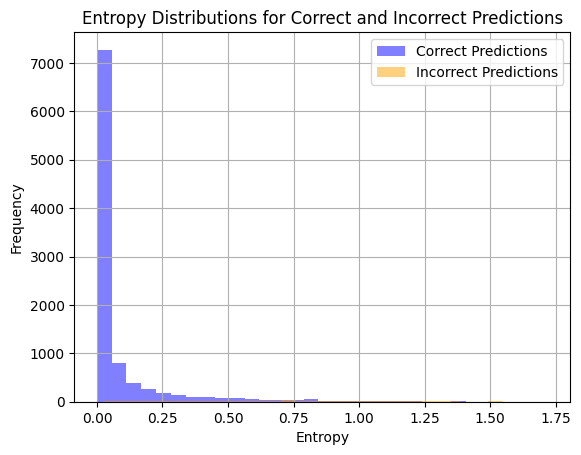

Accuracy of detecting wrong predictions: 0.9671


In [22]:
correct_entropy = entropies[ok_mask]
incorrect_entropy = entropies[err_mask]

import matplotlib.pyplot as plt
plt.hist(correct_entropy, bins=30, alpha=0.5, label='Correct Predictions', color='blue')
plt.hist(incorrect_entropy, bins=30, alpha=0.5, label='Incorrect Predictions', color='orange')
plt.title('Entropy Distributions for Correct and Incorrect Predictions')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

threshold = 0.8 
likely_wrong_mask = entropies > threshold

accuracy = sum(likely_wrong_mask == err_mask) / len(err_mask)
print(f'Accuracy of detecting wrong predictions: {accuracy:.4f}')

### Analysing the last layer

Each neuron $i$ in the last layer of the network corresponds to one class. Its weights $W_i$ can be interpreted as the parameters of a hyperplane $H_i$ of $R^d$, where $d$ is the number of neurons of the previous layer.

If two classes are correctly separated by the network, one can expect that the two corresponding hyperplanes are orthogonal. This can be evaluated by calculating the cosine between their normal vectors. This measure is called.... cosine similarity.

Note that as $d$ increases, the expected value of the cosine of two random normal vectors of $R^d$ converges towards zero. Put otherwise: in high dimension, two random vectors tend to be orthogonal.

Shape of the weights array: (128, 10)


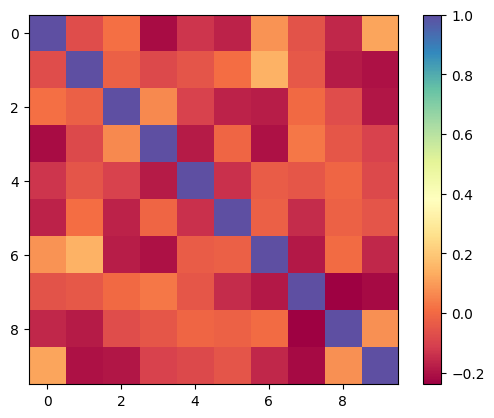

In [23]:
weights, bias = model.get_layer("last").get_weights()
print("Shape of the weights array:", weights.shape)
norms = []
for neuron in range(weights.shape[1]):
    norms += [np.linalg.norm(weights[:,neuron])]
weights /= norms

cos = np.matmul(weights.transpose(), weights)

plt.imshow(cos)
plt.set_cmap('Spectral')
plt.colorbar()
plt.show()

In [24]:
print(cos)

[[ 1.00000012e+00 -7.18310177e-02  1.35090007e-02 -2.13421315e-01
  -1.30030110e-01 -1.67628959e-01  8.21770653e-02 -5.77863827e-02
  -1.61120430e-01  1.18146196e-01]
 [-7.18310177e-02  1.00000024e+00 -2.55891643e-02 -8.38191137e-02
  -5.48267365e-02  8.41782056e-03  1.45054013e-01 -4.26930115e-02
  -1.85304895e-01 -2.01776907e-01]
 [ 1.35090007e-02 -2.55891643e-02  1.00000012e+00  6.57711849e-02
  -1.02096453e-01 -1.70732647e-01 -1.76125079e-01 -6.59917481e-04
  -7.34271333e-02 -1.93606228e-01]
 [-2.13421315e-01 -8.38191137e-02  6.57711849e-02  9.99999821e-01
  -1.82037354e-01 -7.39790732e-03 -2.02115491e-01  2.96453293e-02
  -4.63726968e-02 -1.01729877e-01]
 [-1.30030110e-01 -5.48267365e-02 -1.02096453e-01 -1.82037354e-01
   1.00000024e+00 -1.38936207e-01 -3.18510607e-02 -4.69765477e-02
  -9.70692653e-03 -8.33174735e-02]
 [-1.67628959e-01  8.41782056e-03 -1.70732647e-01 -7.39790732e-03
  -1.38936207e-01  1.00000000e+00 -2.18465570e-02 -1.47707626e-01
  -1.91951320e-02 -5.42831570e-02

Which classes seem to be the most correlated? Would you have expected this?

**Answer**: Obviously, the classes are most correlated with themselves, otherwise 1/4, 1/7, 1/2 are also correlated more than other pairs of classes, might be because thez all have a long line in the digits...

### Improving your network

Try to improve the performance of your network: try different numbers of layers (do not use convolutional layers yet), as well as the number of neurons per layer.

What is your best validation accuracy?

**Answer**: 0.9783

In [25]:
model = Sequential()

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(num_classes, activation='softmax', name="last"))

model.summary()

learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

batch_size = 64
epochs = 40
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last (Dense)                    │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4620 - loss: 1.6903 - val_accuracy: 0.8820 - val_loss: 0.4293
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8856 - loss: 0.3954 - val_accuracy: 0.9185 - val_loss: 0.2908
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9184 - loss: 0.2863 - val_accuracy: 0.9353 - val_loss: 0.2348
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9334 - loss: 0.2290 - val_accuracy: 0.9425 - val_loss: 0.2040
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9444 - loss: 0.1909 - val_accuracy: 0.9512 - val_loss: 0.1721
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9506 - loss: 0.1683 - val_accuracy: 0.9557 - val_loss: 0.1579
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9571 - loss: 0.1472 - val_accuracy: 0.9602 - val_loss: 0.1431
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9595 - loss: 0.1367 - val_accuracy: 0.

### Testing

Testing is the last stage of the learning process. Good practice recommends to do it only once, when you have completely finished with the optimization of the network parameters and hyperparameters.

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.092
Test accuracy: 0.974


### Confusion matrix

Each value $C_{i,j}$ of the confusion matrix $C$ gives the number of elements known to belong to class $i$ that have been classified in class $j$.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


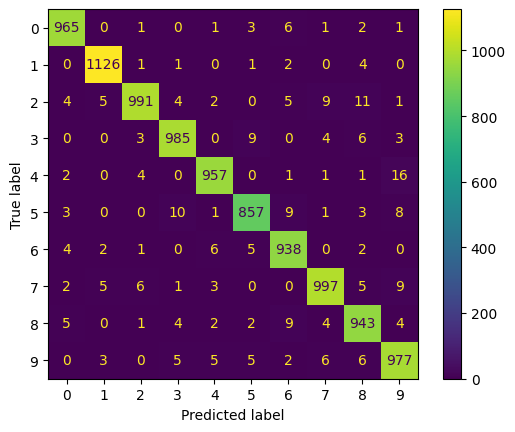

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_proba = model.predict(x_test)
y_pred = y_pred_proba.argmax(axis=-1)

ConfusionMatrixDisplay.from_predictions(y_test_ori, y_pred)
plt.show()

Which pair of classes causes the most confusion? Is it coherent with the analysis of the cosine similarity between neurons of the last layer? Why?

**Answer**: 2 and 7, 3 and 5, 3 and 8, 4 and 9. It is not entirely coherent but that is because the confusion between classes is induced by other factors besides lastvlayer weight similarities (the middle layers also play an important role)

## Using Convolutional Layers

In order experiment with convolutional networks and see their benefits, we can now use convolutional layers.

<u>Formatting input: </u>: since we are going to use convolutional layers we need image data. We can map images back to their original domain in a 28 x 28 grid

In [28]:
x_train_2d = x_train.reshape([-1,28,28,1])
x_val_2d = x_val.reshape([-1,28,28,1])
x_test_2d = x_test.reshape([-1,28,28,1])

Here we will implement our first convolutional neural network. Using keras `Sequential` API, build a CNN with the following sequential architecture:

        - Conv2D: 16 filters and a kernel of size (5x5), ReLU activation
        - MaxPooling2D
        - Conv2D: 32 filters and a kernel of size (3x3), ReLU activation
        - MaxPooling2D
        - Conv2D: 32 filters and a kernel of size (3x3), ReLU activation
        - MLP: 128 neurons, ReLU activation
        - MLP: num_classes neurons
        - Softmax activation

Dont forget, we are now working with images but the MLP layers only takes 1D vector as input.

Use `help(Conv2D)`, etc.. directly in a cell to access the layers API or directly check on [keras](https://keras.io/api/)

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Softmax

model = Sequential()

model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=x_train_2d.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10))
model.add(Softmax())

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,586 (205.41 KB)

 Trainable params: 52,586 (205.41 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [31]:
batch_size = 64
epochs = 40
output = model.fit(x_train_2d, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val_2d, y_val),
)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5031 - loss: 1.5197 - val_accuracy: 0.9223 - val_loss: 0.2726
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9196 - loss: 0.2624 - val_accuracy: 0.9522 - val_loss: 0.1630
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9520 - loss: 0.1582 - val_accuracy: 0.9650 - val_loss: 0.1203
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9648 - loss: 0.1179 - val_accuracy: 0.9682 - val_loss: 0.1029
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9717 - loss: 0.0953 - val_accuracy: 0.9773 - val_loss: 0.0825
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9739 - loss: 0.0845 - val_accuracy: 0.9795 - val_loss: 0.0714
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9763 - loss: 0.0743 - val_accuracy: 0.9793 - val_loss: 0.0704
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9791 - loss: 0.0680 - val_accuracy: 0.

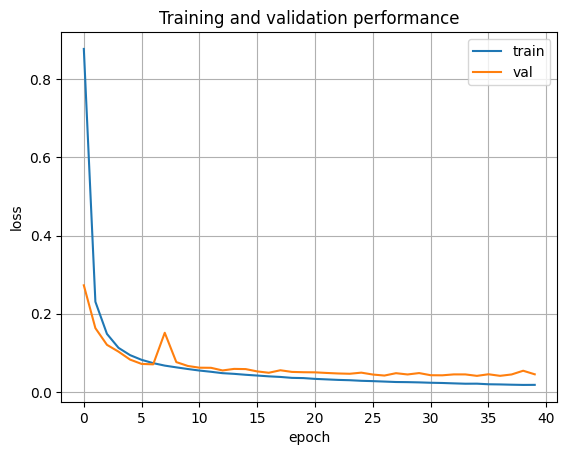

In [32]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()
# plt.ylim(0.2, 0.8)

Is it overfitting? What can you say about it when you compare with the denser architecture?
What else can you do to reduce it?

**Answer:** It is overfitting after 15-20 epochs.
A denser architecture makes it overfit less, we can also use regularization techniques to achieve this.

In [33]:
score = model.evaluate(x_test_2d, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.036
Test accuracy: 0.989


# Visualizing the Feature Maps

We can try to understand what is happening in the network by looking at its feature maps. Since they are defined on a grid, we can vizualize them as images.

Here we vizualize the feature maps of the first layer for some images.

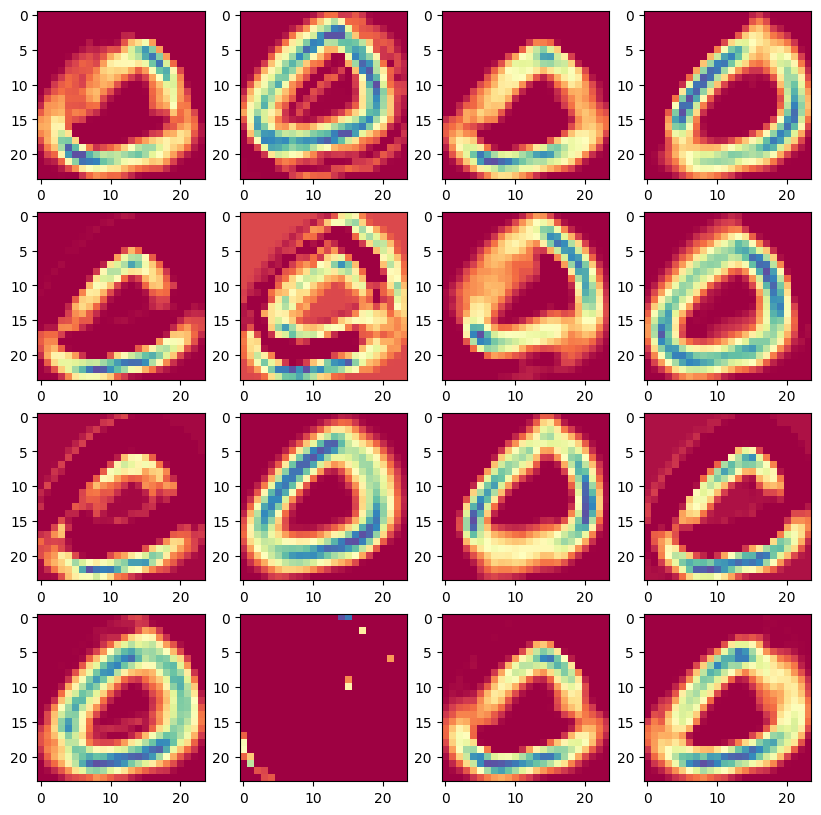

In [34]:
%matplotlib inline

im = x_test_2d[np.random.randint(0, x_test_2d.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

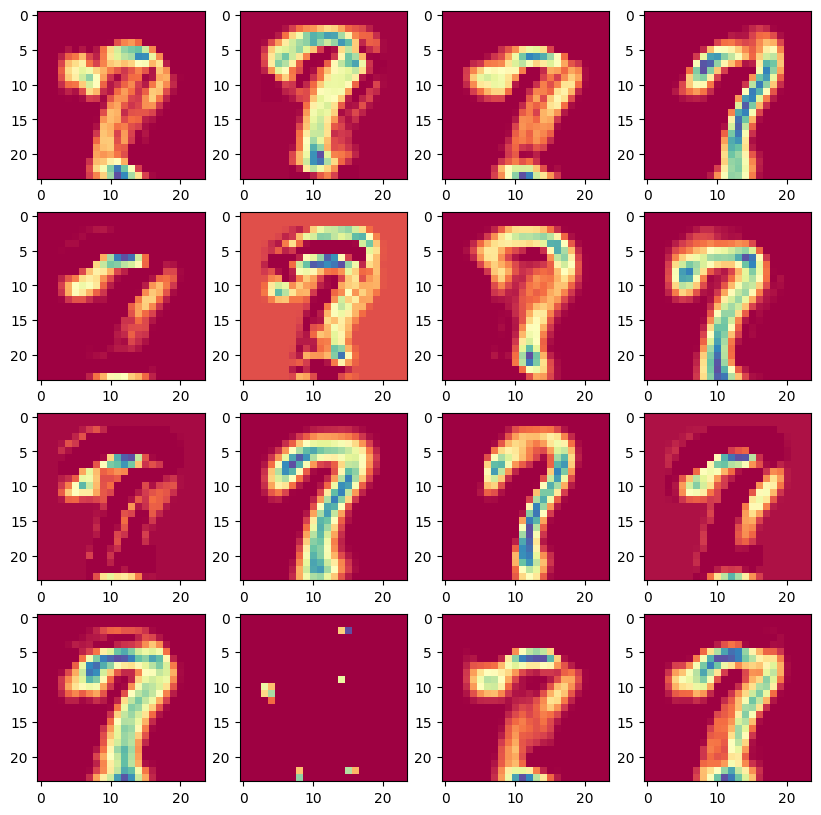

In [35]:
%matplotlib inline

im = x_test_2d[np.random.randint(0, x_test_2d.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

Can you identify if the convolutional layer detects meaningful features?(for example edges and corners)

**Answer:** It does, the global shape, the important edges and corners are all extracted using the first layer.

# Improving your network

As before, try to improve your network by changing the number of layers of each type and the number of feature maps, neurons or kernel size.

In [36]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train_2d.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization

model.add(Dense(10, activation='softmax'))  # 10 classes for classification

model.summary()

learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

batch_size = 64
epochs = 40
output = model.fit(x_train_2d, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val_2d, y_val),
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4423 - loss: 1.6833 - val_accuracy: 0.9123 - val_loss: 0.2953
Epoch 2/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8833 - loss: 0.3848 - val_accuracy: 0.9482 - val_loss: 0.1730
Epoch 3/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9244 - loss: 0.2564 - val_accuracy: 0.9637 - val_loss: 0.1254
Epoch 4/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9425 - loss: 0.1944 - val_accuracy: 0.9625 - val_loss: 0.1240
Epoch 5/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9518 - loss: 0.1601 - val_accuracy: 0.9722 - val_loss: 0.0955
Epoch 6/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9573 - loss: 0.1402 - val_accuracy: 0.9753 - val_loss: 0.0800
Epoch 7/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9625 - loss: 0.1258 - val_accuracy: 0.9787 - val_loss: 0.0708
Epoch 8/40
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9654 - loss: 0.1157 - val_accuracy: 0.


What is your best validation accuracy?

**Answer**: 0.9893

In [37]:
score = model.evaluate(x_test_2d, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 0.024
Test accuracy: 0.991


# Optional: Experimenting with a more complex database

We will now move to the fashion MNIST database, in order to experiment with a more complex database. The best test accuracy reported on this database is 0.967 (see https://github.com/zalandoresearch/fashion-mnist).



In [38]:
from tensorflow.keras.datasets import fashion_mnist as db

# You can use the following dictionary to transform number labels into meaningful labels:
fashion_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
    }

print(fashion_dict[2])

Pullover


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


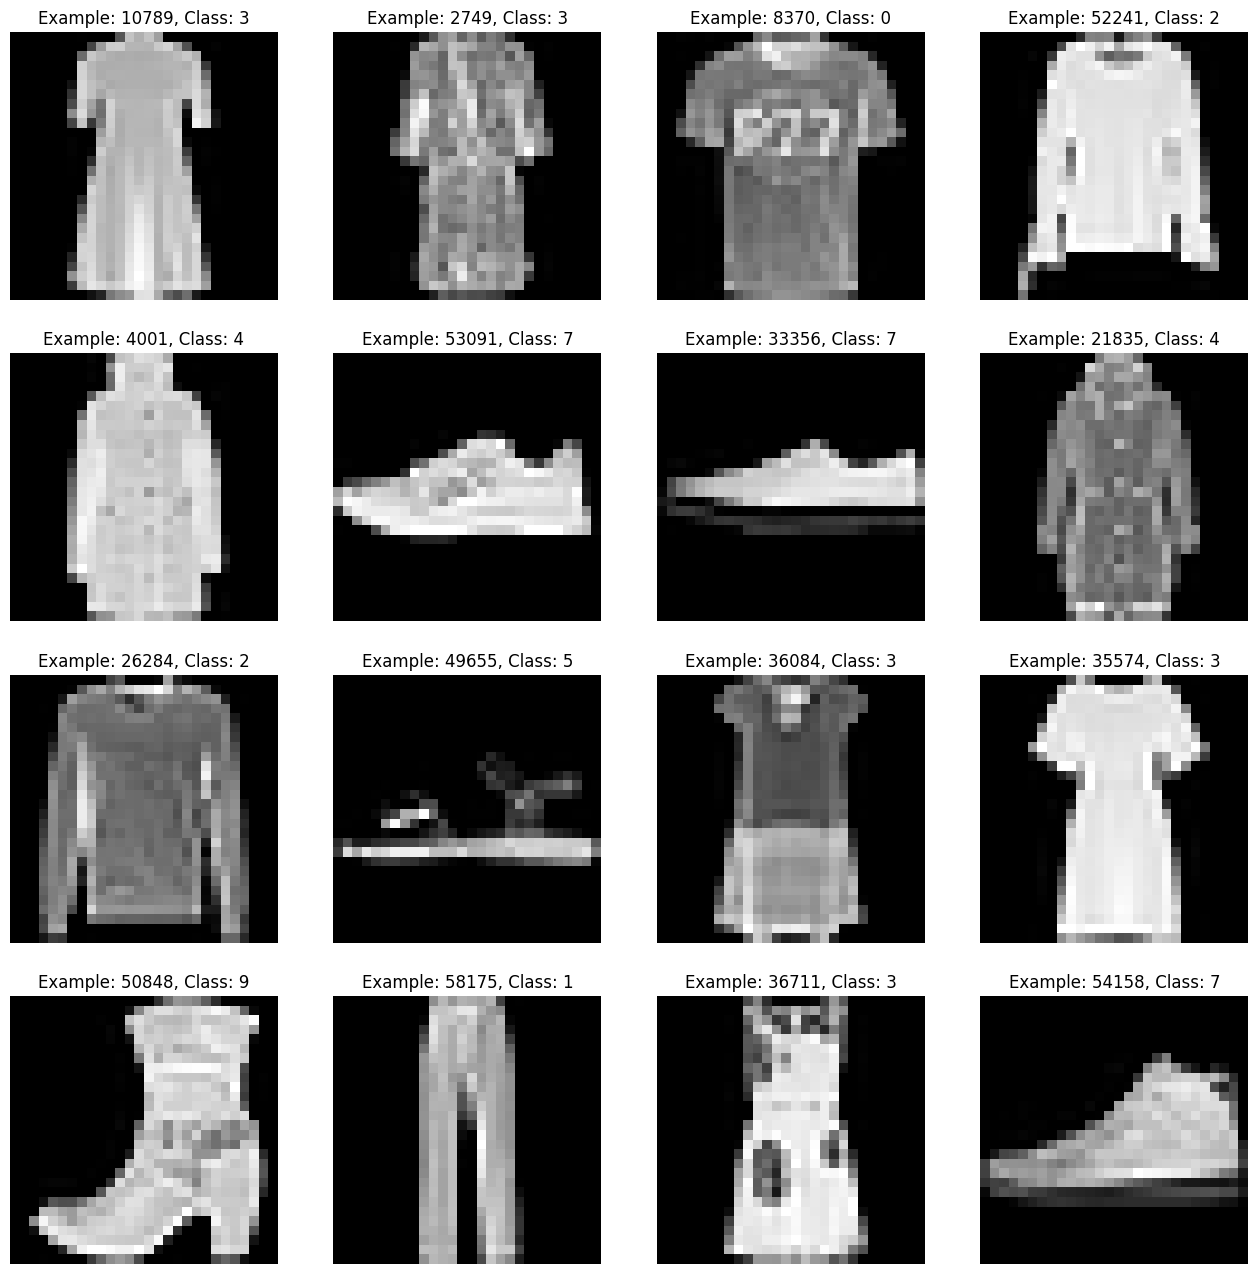

In [39]:
# Load and have a look at the data
(x, y), (x_test_ori, y_test_ori) = db.load_data()

# Visualize a single digit, with its class
plt_r,plt_c = 4,4
f, ax = plt.subplots(plt_r, plt_c, figsize=(16,16))
for i in range(plt_r):
    for j in range(plt_c):
        index = np.random.randint(x.shape[0])
        ax[i][j].imshow(x[index], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title("Example: {}, Class: {}".format(index, y[index]))
plt.show()

Build your own model below, train it on the fashion MNIST database and analyse its results. Dont forget to normalize and put the data into the correct format. Try to reach the highest validation accuracy. Finally, evaluate it using the test database.

You must respect the following constraints:

* you can use dense, convolutional, and pooling layers in your network;

* do not change the optimizer, the loss or the metrics used during training.



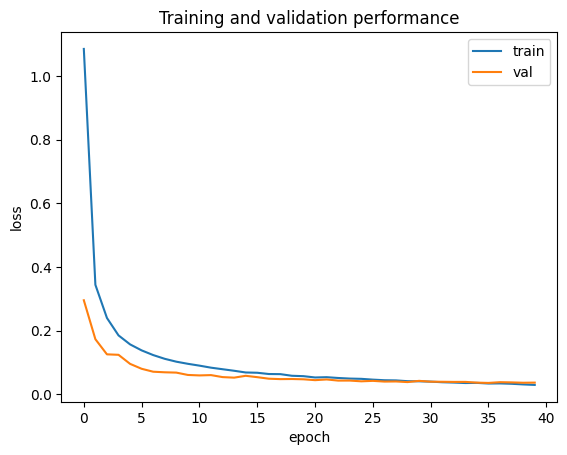

In [41]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid
plt.show()
# plt.ylim(0.2, 0.8)

# Your results on the fashion MNIST database

Which pairs of classes are the main cause of confusion?

**Answer**: ...


Did you use an architecture different than the one used for MNIST? If so, how?

**Answer**: ...


Is there overfitting?

**Answer**: ...

**Test accuracy**: ...